In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L2hvbWUva2V2aW5zaWxiZXJiZXJnL1VDU0MvQU0yMzgvZG9jcy9odzI="
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using GLMakie
using QuadGK

# cumulative trapazoidal rule
function cumsumtrap(f::Function, x)
    y = f.(x)
    N = length(x)
    x1 = @view x[1:N-1]
    x2 = @view x[2:N]
    y1 = @view y[1:N-1]
    y2 = @view y[2:N]
    integral = cumsum(((x2.-x1).*(y1.+y2))./2.0)
    integral ./= integral[end]
    return [0; integral]
end

# CDF inverse sampler
function sampleInverseCDF(x::Float64, points::Matrix{Float64})
    idx = findfirst(points[:, 1] .> x)
    if idx === nothing
        p1 = points[end-1, :]
        p2 = points[end, :]
    elseif idx == 1
        p1 = points[1, :]
        p2 = points[2, :]
    else
        p1 = points[idx-1, :]
        p2 = points[idx, :]
    end
    liy(x, p1, p2)        
end

# Linear Interpolator
function liy(x::Float64, p1::Vector{Float64}, p2::Vector{Float64})
    x1, y1 = p1
    x2, y2 = p2
    if isapprox(x1, x2, atol = 1e-12)
        return (y1 + y2) / 2.0
    end
    return y1 + (x - x1)*(y2 - y1)/(x2 - x1)
end

# Sine Integral
function Si(x::Float64)
    return x == 0.0 ? 0.0 : quadgk(t -> sin(t)/t, 0.0, x, rtol=1e-3)[1]
end

# joint PDF for problem 2 p(x, y)
function p(x::Float64, y::Float64)
    if x < 0.0 || y < 0.0
        return 0.0
    end
    return ((40.0)/(Si(20.0) + 20.0))*cos(10.0*x*y)*cos(10.0*x*y)
end

# Conditional PDF p(x | y)
function pxGy(x::Float64, y::Float64)
    denom = (20.0*y+sin(20.0*y))
    if abs(denom) < 1e-6
        return 0.0
    end
    return (40.0*y*cos(10.0*x*y)*cos(10.0*x*y))/denom
end

# Conditional PDF p(y | x)
function pyGx(x::Float64, y::Float64)
    denom = (20.0*x+sin(20.0*x))
    if abs(denom) < 1e-6
        return 0.0
    end
    return (40.0*x*cos(10.0*x*y)*cos(10.0*x*y))/denom
end

# Mesh of the surface of the joint PDF
function getSurface()
    xs = LinRange(0, 1, 100)
    ys = LinRange(0, 1, 100)
    zs = [p(x, y) for x in xs, y in ys]
    return xs, ys, zs
end

# gibbs sampler
function gibbsSample(N::Integer)
    samples = Matrix{Float64}(undef, N, 2)
    r = LinRange(0.0, 1.0, 1000)
    # initialize random x1
    y0 = rand()
    samples[1, 1] = sampleInverseCDF(rand(), hcat(cumsumtrap(x -> pxGy(x, y0), r), r))
    for i=2:N
        samples[i-1, 2] = sampleInverseCDF(rand(), hcat(cumsumtrap(y -> pyGx(samples[i-1, 1], y), r), r))
        samples[i, 1] = sampleInverseCDF(rand(), hcat(cumsumtrap(x -> pxGy(x, samples[i-1, 2]), r), r))
    end
    samples
end

# Part B problem solution
function partb(N::Integer)
    fig = Figure()
    ax = Axis(fig[1,1])
    xs, ys, zs = getSurface()
    co = contourf!(ax, xs, ys, zs,
                   extendlow = :auto,
                   extendhigh = :auto)
    samples = gibbsSample(N)
    scatter!(ax, samples[:, 1], samples[:, 2], markersize = 3, color = :red)
    Colorbar(fig[1, 2], co)
    save("q2partb.png", fig)
end
partb(5000);

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/6c4lt/src/scenes.jl:229


In [3]:
function f(y::Float64, X1::Float64, X2::Float64)
    return sin(4*π*X1*y) + cos(4*π*X2*y)
end

function partc()
    N = Int64(5e4)
    M = Int64(500)
    r = LinRange(0.0, 1.0, M)
    fig = Figure()
    grid = fig[1, 1] = GridLayout()
    ax = Axis(grid[1, 1],
              title = "y by sample mean and standard deviation",
              xlabel = "y")
    samples = Matrix{Float64}(undef, N, M)
    for i=1:N
        X1, X2 = gibbsSample(2)[:, 1]
        for j=1:M
            samples[i, j] = f(r[j], X1, X2)
        end
    end
    μᵢ = vec(sum(j -> j, samples, dims=1) ./ N)
    μₜ = sum(μᵢ) / M
    σᵢ = vec(sqrt.(sum((samples .- μᵢ') .^ 2, dims = 1) ./ (N - 1)))
    means = lines!(ax, r, μᵢ, color = :red)
    stdv = lines!(ax, r, σᵢ, color = :blue)
    Legend(fig[1, 2], [means, stdv], ["mean", "std dev"])
    save("q2partc.png", fig)
end
partc();

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/6c4lt/src/scenes.jl:229


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/6c4lt/src/scenes.jl:229


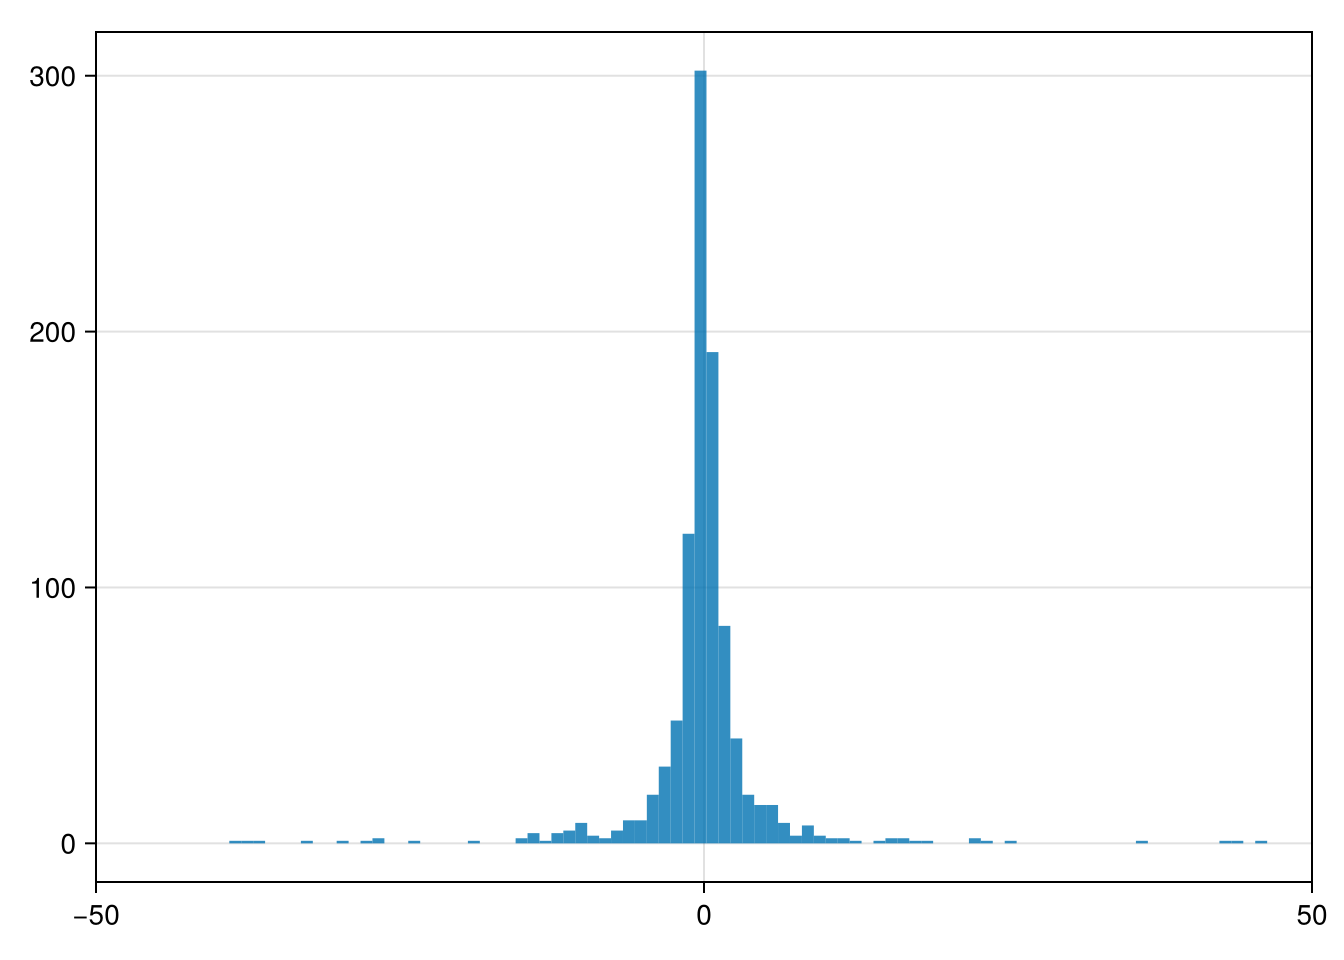

In [4]:
function q3p(x::Float64)
    return 1.0 / (π*(1+x^2))
end

function q3cdf(x::Float64)
    return tan(π*(x - 0.5))
end

function q3(N::Integer)
    samples = Vector{Float64}(undef, N)
    for i in eachindex(samples)
        samples[i] = q3cdf(rand())
    end
    
    fig = Figure()
    grid = fig[1, 1] = GridLayout()
    ax = Axis(grid[1, 1])
    hist!(ax, samples, bins = 1000)
    xlims!(ax, -50, 50)

    display(fig)
end
q3(1000);